In [1]:
import os
import re
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.models import Model, Sequential

# Helper Functions
### Import and clean data

Helper function `clean` to remove IP addresses, datetimes, https addresses and usernames.

In [2]:
def clean(text):
    text = re.sub(r'[0-9"]', '', text)
    text = re.sub(r'#[\S]+\b', '', text)
    text = re.sub(r'@[\S]+\b', '', text)
    text = re.sub(r'https?\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [3]:
def encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts,
        return_attention_masks=False,
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    return np.array(enc_di['input_ids'])

## Loading Data

In [4]:
kaggle = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification/'
train1 = pd.read_csv(f'{kaggle}jigsaw-toxic-comment-train.csv')
train2 = pd.read_csv(f'{kaggle}jigsaw-unintended-bias-train.csv')
valid = pd.read_csv(f'{kaggle}validation.csv')
test = pd.read_csv(f'{kaggle}test.csv')

In [5]:
train1['comment_text'] = train1['comment_text'].apply(clean)
train2['comment_text'] = train2['comment_text'].apply(clean)
train2['toxic'] = train2.toxic.round().astype(int)
valid['comment_text'] = valid['comment_text'].apply(clean)
test['content'] = test['content'].apply(clean)

In [6]:
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']]
])

train = train.sample(frac=1)
train1 = train.iloc[0: len(train)//2]
train2 = train.iloc[len(train)//2: len(train)]

# Data Visualizations

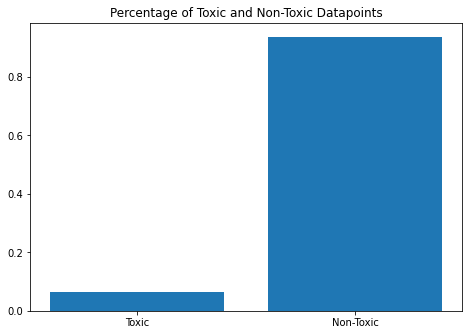

In [7]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title('Percentage of Toxic and Non-Toxic Datapoints')
labels = ['Toxic', 'Non-Toxic']
values = [len(train[train['toxic']==1])/len(train), len(train[train['toxic']==0])/len(train)]
ax.bar(labels, values)
plt.show()

# Tokenization
Using XLM-Roberta (Base)

In [8]:
tokenizer = transformers.AutoTokenizer.from_pretrained('jplu/tf-xlm-roberta-large')

In [9]:
%%time

x_train1 = encode(train1.comment_text.values, tokenizer, maxlen=192)
x_train2 = encode(train2.comment_text.values, tokenizer, maxlen=192)

y_train1 = train1.toxic.values
y_train2 = train2.toxic.values

x_valid = encode(valid.comment_text.values, tokenizer, maxlen=192)
x_test = encode(test.content.values, tokenizer, maxlen=192)

CPU times: user 22min 35s, sys: 12 s, total: 22min 47s
Wall time: 22min 47s


Save tokenized IDs seperate from the toxic labels.

# Seperating Training Data into Several Files

In [10]:
np.save('x_train1', x_train1)
np.save('x_train2', x_train2)
np.save('y_train1', y_train1)
np.save('y_train2', y_train2)

In [11]:
np.save('x_valid', x_valid)
np.save('x_test', x_test)
np.save('y_valid', valid.toxic.values)